In [13]:
# General Imports
import os
import numpy as np
import pandas as pd
from time import strftime, localtime
import matplotlib.pyplot as plt
#from utilities import create_analysis_report, load_validation_set_raw
from skimage.transform import resize

import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, cohen_kappa_score

SLIM_PATH = '/srv/workspace/research/mlml/models/research/slim'
os.chdir(SLIM_PATH)

# Deep Learning
import tensorflow as tf
from nets import inception
from datasets import dataset_utils
from preprocessing import inception_preprocessing
from tensorflow.contrib import slim

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, \
    hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import check_random_state

plt.rcParams.update({'font.size': 22})
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

SOURCE_PATH = "/srv/workspace/research/mlml/mlml_weightedLoss/"
IMAGES_PATH = "/srv/workspace/research/mlml/datasets/mscoco/train_formatted_npz/"
TEST_IMAGES_PATH = "/srv/workspace/research/mlml/datasets/mscoco/val_formatted_npz/"
OUTPUT_PATH ="/srv/workspace/research/mlml/experiments_results/"
PRETRAINED_MODEL_DIR = '/srv/workspace/research/mlml/pretrained_models/'

#EXPERIMENTNAME = "pretrained_inceptionnet_first_run"
INPUT_SHAPE = (224, 224, 3)
INPUT_IMAGE_MEAN = [0.485, 0.456, 0.406]
INPUT_IMAGE_STD = [0.229, 0.224, 0.225]

labels_set = pd.read_csv('/srv/workspace/research/mlml/mlml_weightedLoss/labels/missing_labels0.0.csv')
test_global_labels = pd.read_csv('/srv/workspace/research/mlml/datasets/mscoco/ms_val_binarized_labels.csv')

LABELS_LIST = labels_set.columns[3:]
NUM_CLASSES = len(LABELS_LIST)

# Training paramaeters
BATCH_SIZE = 32
TRAINING_STEPS = int(len(labels_set)/BATCH_SIZE)
#TRAINING_STEPS = 5
#VALIDATION_STEPS = 156
NUM_EPOCHS = 2
Pos_balance_weights = np.round(1 / (np.sum(labels_set.iloc[:,3:].values, axis = 0)/ len(labels_set)))


In [10]:
# Define helper functions
def download_pretrained_model():
    url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
    if not tf.gfile.Exists(PRETRAINED_MODEL_DIR):
        tf.gfile.MakeDirs(PRETRAINED_MODEL_DIR)

    dataset_utils.download_and_uncompress_tarball(url, PRETRAINED_MODEL_DIR)

def get_weights(shape):
    w = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    #variable_summaries(w)
    return w


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    b = tf.Variable(initial)
    #variable_summaries(b)
    return b

def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = get_weights([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b


def dataset_from_csv(csv_path, **kwargs):
    """
        Load dataset from a csv file.
        kwargs are forwarded to the pandas.read_csv function.
    """
    df = pd.read_csv(csv_path, **kwargs)

    dataset = (
        tf.data.Dataset.from_tensor_slices(
            {
                key:df[key].values
                for key in df
            }
        )
    )
    return dataset


def set_tensor_shape(tensor, tensor_shape):
        """
            set shape for a tensor (not in place, as opposed to tf.set_shape)
        """
        tensor.set_shape(tensor_shape)
        return tensor

def mscoco_labels_idx_to_names(labels,labelnames = LABELS_LIST):
    return labelnames[np.where(labels == 1)]


def load_image_npz(*args):
    """
        loads spectrogram with error tracking.
        args : song ID, path to dataset
        return:
            Features: numpy ndarray, computed features (if no error occured, otherwise: 0)
            Error: boolean, False if no error, True if an error was raised during features computation.
    """
    # TODO: edit path
    path = IMAGES_PATH
    image_id, dummy_path = args
    try:
        # tf.logging.info(f"Load spectrogram for {song_id}")
        image = np.load(os.path.join(path, str(image_id) + '.npz'))['image']
        image = image.astype(np.float32)
        image /= 255.0
        image = (image - INPUT_IMAGE_MEAN) / INPUT_IMAGE_STD
        #image -= 0.5 ; image *= 2.0
        image = resize(image, INPUT_SHAPE)
        image = image.astype(np.float32)
        # image = tf.keras.preprocessing.image.array_to_img(image,data_format='channels_last')
        return image, False
    except Exception as err:
        print("\n Error while computing features for " + str(image_id) + '\n')
        return np.float32(0.0), True


def load_imge_tf(sample, identifier_key="index",
                 path="/srv/workspace/research/mlml/datasets/mscoco/train_formatted_npz/", device="/cpu:0",
                 features_key="features"):
    """
        wrap load_images into a tensorflow function.
    """
    with tf.device(device):
        input_args = [sample[identifier_key], tf.constant(path)]
        res = tf.py_func(load_image_npz,
                         input_args,
                         (tf.float32, tf.bool),
                         stateful=False),
        image, error = res[0]
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        res = dict(list(sample.items()) + [(features_key, image), ("error", error)])
        return res

# Dataset pipelines
def get_labels_py(image_id):
    labels = global_labels[global_labels.index == image_id]
    labels = labels.iloc[:, 3:].values.flatten() # TODO: fix this shift in dataframe columns when read
    labels = labels.astype(np.float32)
    return labels


def tf_get_labels_py(sample, device="/cpu:0"):
    with tf.device(device):
        input_args = [sample["index"]]
        labels = tf.py_func(get_labels_py,
                            input_args,
                            [tf.float32],
                            stateful=False)
        res = dict(list(sample.items()) + [("binary_label", labels)])
        return res


def get_dataset(input_csv, input_shape=INPUT_SHAPE, batch_size=BATCH_SIZE, shuffle=True,
                infinite_generator=True, random_crop=False,
                num_parallel_calls=32):
    # build dataset from csv file
    dataset = dataset_from_csv(input_csv)
    # Shuffle data
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100, seed=0, reshuffle_each_iteration=True)

    # load image
    dataset = dataset.map(lambda sample: load_imge_tf(sample), num_parallel_calls=1)

    # filter out errors
    dataset = dataset.filter(lambda sample: tf.logical_not(sample["error"]))

    # resize image
    # dataset = dataset.map(lambda sample: dict(sample, features=tf.image.resize_images(sample['features'], (224, 224))),
    #                      num_parallel_calls=num_parallel_calls)

    # Apply permute dimensions
    # dataset = dataset.map(lambda sample: dict(sample, features=tf.transpose(sample["features"], perm=[1, 2, 0])),
    #                      num_parallel_calls=num_parallel_calls)

    # set features shape
    dataset = dataset.map(lambda sample: dict(sample,
                                              features=set_tensor_shape(sample["features"], input_shape)))

    # if cache_dir:
    #    os.makedirs(cache_dir, exist_ok=True)
    #    dataset = dataset.cache(cache_dir)

    dataset = dataset.map(lambda sample: tf_get_labels_py(sample), num_parallel_calls=1)

    # set output shape
    dataset = dataset.map(lambda sample: dict(sample, binary_label=set_tensor_shape(
        sample["binary_label"], (NUM_CLASSES))))

    if infinite_generator:
        # Repeat indefinitly
        dataset = dataset.repeat(count=-1)

    # Make batch
    dataset = dataset.batch(batch_size)

    # Select only features and annotation
    dataset = dataset.map(lambda sample: (sample["features"], sample["binary_label"]))

    return dataset


def plot_loss_acuracy(epoch_losses_history, epoch_accurcies_history, val_losses_history, val_accuracies_history, path):
    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 10))
    plt.plot(epoch_accurcies_history)
    plt.plot(val_accuracies_history)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(path, "model_accuracy.png"))
    plt.savefig(os.path.join(path, "model_accuracy.pdf"), format='pdf')
    # plt.savefig(os.path.join(path,label + "_model_accuracy.eps"), format='eps', dpi=900)
    # Plot training & validation loss values
    plt.figure(figsize=(10, 10))
    plt.plot(epoch_losses_history)
    plt.plot(val_losses_history)
    plt.title('Model loss (Cross Entropy without weighting)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(path, "model_loss.png"))
    plt.savefig(os.path.join(path, "model_loss.pdf"), format='pdf')
    # plt.savefig(os.path.join(path,label + "_model_loss.eps"), format='eps', dpi=900)
    
def load_test_set_raw(image_path=TEST_IMAGES_PATH):
    # Loading testset groundtruth
    test_ground_truth = pd.read_csv('/srv/workspace/research/mlml/datasets/mscoco/ms_val_binarized_labels.csv')
    test_classes = test_ground_truth.values[:,2:]
    test_classes = test_classes.astype(int)
    images_ids = test_ground_truth.iloc[:,1]

    test_images = np.zeros([len(test_ground_truth), 224, 224,3])
    songs_ID = np.zeros([len(test_ground_truth), 1])
    for idx, filename in enumerate(list(images_ids)):
        image = np.load(os.path.join(image_path, str(filename) + '.npz'))['image']
        image = image.astype(np.float32)
        image /= 255.0
        image = (image - INPUT_IMAGE_MEAN) / INPUT_IMAGE_STD
        #image -= 0.5 ; image *= 2.0
        image = resize(image, INPUT_SHAPE)
        image = image.astype(np.float32)
        test_images[idx] = image
    return test_images, test_classes

def create_analysis_report(model_output, groundtruth, output_path, LABELS_LIST, validation_output=None,
                           validation_groundtruth=None):
    """
    Create a report of all the different evaluation metrics, including optimizing the threshold with the validation set
    if it is passed in the parameters
    """
    # Round the probabilities at 0.5
    model_output_rounded = np.round(model_output)
    model_output_rounded = np.clip(model_output_rounded, 0, 1)
    # Create a dataframe where we keep all the evaluations, starting by prediction accuracy
    accuracies_perclass = sum(model_output_rounded == groundtruth) / len(groundtruth)
    results_df = pd.DataFrame(columns=LABELS_LIST)
    results_df.index.astype(str, copy=False)
    percentage_of_positives_perclass = sum(groundtruth) / len(groundtruth)
    results_df.loc[0] = percentage_of_positives_perclass
    results_df.loc[1] = accuracies_perclass
    results_df.index = ['Ratio of positive samples', 'Model accuracy']

    # plot the accuracies per class
    results_df.T.plot.bar(figsize=(22, 12), fontsize=18)
    plt.title('Model accuracy vs the ratio of positive samples per class')
    plt.xticks(rotation=45)
    plt.savefig(os.path.join(output_path, "accuracies_vs_positiveRate.pdf"), format="pdf")
    plt.savefig(os.path.join(output_path, "accuracies_vs_positiveRate.png"))

    # Getting the true positive rate perclass
    true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(groundtruth)
    results_df.loc[2] = true_positives_ratio_perclass
    # Get true negative ratio
    true_negative_ratio_perclass = sum((model_output_rounded == groundtruth)
                                       * (groundtruth == 0)) / (len(groundtruth) - sum(groundtruth))
    results_df.loc[3] = true_negative_ratio_perclass
    # compute additional metrics (AUC,f1,recall,precision)
    auc_roc_per_label = roc_auc_score(groundtruth, model_output, average=None)
    precision_perlabel = precision_score(groundtruth, model_output_rounded, average=None)
    recall_perlabel = recall_score(groundtruth, model_output_rounded, average=None)
    f1_perlabel = f1_score(groundtruth, model_output_rounded, average=None)
    kappa_perlabel = [cohen_kappa_score(groundtruth[:, x], model_output_rounded[:, x]) for x in range(len(LABELS_LIST))]
    results_df = results_df.append(
        pd.DataFrame([auc_roc_per_label,recall_perlabel, precision_perlabel, f1_perlabel, kappa_perlabel], columns=LABELS_LIST))
    results_df.index = ['Ratio of positive samples', 'Model accuracy', 'True positives ratio',
                        'True negatives ratio', "AUC", "Recall", "Precision", "f1-score", "Kappa score"]

    # Creating evaluation plots
    plot_true_poisitve_vs_all_positives(model_output_rounded, groundtruth,
                                        os.path.join(output_path, 'TruePositive_vs_allPositives'), LABELS_LIST)
    plot_output_coocurances(model_output_rounded, os.path.join(output_path, 'output_coocurances'), LABELS_LIST)
    plot_false_netgatives_confusion_matrix(model_output_rounded, groundtruth,
                                           os.path.join(output_path, 'false_negative_coocurances'), LABELS_LIST)

    # Adjusting threshold based on validation set
    if (validation_groundtruth is not None and validation_output is not None):
        np.savetxt(os.path.join(output_path, 'validation_predictions.out'), validation_output, delimiter=',')
        np.savetxt(os.path.join(output_path, 'valid_ground_truth_classes.txt'), validation_groundtruth, delimiter=',')
        thresholds = np.arange(0, 1, 0.01)
        f1_array = np.zeros((len(LABELS_LIST), len(thresholds)))
        for idx, label in enumerate(LABELS_LIST):
            f1_array[idx, :] = [
                f1_score(validation_groundtruth[:, idx], np.clip(np.round(validation_output[:, idx] - threshold + 0.5), 0, 1))
                for threshold in thresholds]
        threshold_arg = np.argmax(f1_array, axis=1)
        threshold_per_class = thresholds[threshold_arg]

        # plot the f1 score across thresholds
        plt.figure(figsize=(20, 20))
        for idx, x in enumerate(LABELS_LIST):
            plt.plot(thresholds, f1_array[idx, :], linewidth=5)
        plt.legend(LABELS_LIST, loc='best')
        plt.title("F1 Score vs different prediction threshold values for each class")
        plt.savefig(os.path.join(output_path, "f1_score_vs_thresholds.pdf"), format="pdf")
        plt.savefig(os.path.join(output_path, "f1_score_vs_thresholds.png"))

        # Applying thresholds optimized per class
        model_output_rounded = np.zeros_like(model_output)
        for idx, label in enumerate(LABELS_LIST):
            model_output_rounded[:, idx] = np.clip(np.round(model_output[:, idx] - threshold_per_class[idx] + 0.5), 0, 1)

        accuracies_perclass = sum(model_output_rounded == groundtruth) / len(groundtruth)
        # Getting the true positive rate perclass
        true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(
            groundtruth)
        # Get true negative ratio
        true_negative_ratio_perclass = sum((model_output_rounded == groundtruth)
                                           * (groundtruth == 0)) / (len(groundtruth) - sum(groundtruth))
        results_df = results_df.append(
            pd.DataFrame([accuracies_perclass, true_positives_ratio_perclass,
                          true_negative_ratio_perclass], columns=LABELS_LIST))
        # compute additional metrics (AUC,f1,recall,precision)
        auc_roc_per_label = roc_auc_score(groundtruth, model_output, average=None)
        precision_perlabel = precision_score(groundtruth, model_output_rounded, average=None)
        recall_perlabel = recall_score(groundtruth, model_output_rounded, average=None)
        f1_perlabel = f1_score(groundtruth, model_output_rounded, average=None)
        kappa_perlabel = [cohen_kappa_score(groundtruth[:, x], model_output_rounded[:, x]) for x in
                          range(len(LABELS_LIST))]
        results_df = results_df.append(
            pd.DataFrame([auc_roc_per_label,recall_perlabel, precision_perlabel, f1_perlabel,kappa_perlabel],
                         columns=LABELS_LIST))
        results_df.index = ['Ratio of positive samples', 'Model accuracy', 'True positives ratio',
                            'True negatives ratio', "AUC", "Precision", "Recall", "f1-score",  "Kappa score",
                            'Optimized model accuracy', 'Optimized true positives ratio',
                            'Optimized true negatives ratio', "Optimized AUC",
                            "Optimized precision", "Optimized recall", "Optimized f1-score",  "Optimized Kappa score"]

        # Creating evaluation plots
        plot_true_poisitve_vs_all_positives(model_output_rounded, groundtruth,
                                            os.path.join(output_path, 'TruePositive_vs_allPositives[optimized]'),
                                            LABELS_LIST)
        plot_output_coocurances(model_output_rounded, os.path.join(output_path, 'output_coocurances[optimized]'),
                                LABELS_LIST)
        plot_false_netgatives_confusion_matrix(model_output_rounded, groundtruth,
                                               os.path.join(output_path, 'false_negative_coocurances[optimized]'),
                                               LABELS_LIST)
    results_df['average'] = results_df.mean(numeric_only=True, axis=1)
    results_df.T.to_csv(os.path.join(output_path, "results_report.csv"), float_format="%.2f")
    return results_df


def evaluate_model(test_pred_prob, test_classes, saving_path, evaluation_file_path):
    """
    Evaluates a given model using accuracy, area under curve and hamming loss
    :param model: model to be evaluated
    :param spectrograms: the test set spectrograms as an np.array
    :param test_classes: the ground truth labels
    :return: accuracy, auc_roc, hamming_error
    """
    test_pred = np.round(test_pred_prob)
    # Accuracy
    accuracy = 100 * accuracy_score(test_classes, test_pred)
    print("Exact match accuracy is: " + str(accuracy) + "%")
    # Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    auc_roc = roc_auc_score(test_classes, test_pred_prob)
    print("Macro Area Under the Curve (AUC) is: " + str(auc_roc))
    auc_roc_micro = roc_auc_score(test_classes, test_pred_prob, average="micro")
    print("Micro Area Under the Curve (AUC) is: " + str(auc_roc_micro))
    auc_roc_weighted = roc_auc_score(test_classes, test_pred_prob, average="weighted")
    print("Weighted Area Under the Curve (AUC) is: " + str(auc_roc_weighted))
    # Hamming loss is the fraction of labels that are incorrectly predicted.
    hamming_error = hamming_loss(test_classes, test_pred)
    print("Hamming Loss (ratio of incorrect tags) is: " + str(hamming_error))
    with open(evaluation_file_path, "w") as f:
        f.write("Exact match accuracy is: " + str(accuracy) + "%\n" + "Area Under the Curve (AUC) is: " + str(auc_roc)
                + "\nMicro AUC is:" + str(auc_roc_micro) + "\nWeighted AUC is:" + str(auc_roc_weighted)
                + "\nHamming Loss (ratio of incorrect tags) is: " + str(hamming_error))
    print("saving prediction to disk")
    np.savetxt(os.path.join(saving_path, 'predictions.out'), test_pred_prob, delimiter=',')
    np.savetxt(os.path.join(saving_path, 'test_ground_truth_classes.txt'), test_classes, delimiter=',')
    return accuracy, auc_roc, hamming_error

def plot_true_poisitve_vs_all_positives(model_output_rounded, groundtruth, output_path, LABELS_LIST):
    # Creating a plot of true positives vs all positives
    true_positives_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1))
    true_positives_df = pd.DataFrame(columns=LABELS_LIST)
    true_positives_df.index.astype(str, copy=False)
    true_positives_df.loc[0] = true_positives_perclass
    percentage_of_positives_perclass = sum(groundtruth)
    true_positives_df.loc[1] = percentage_of_positives_perclass
    true_positives_df.index = ['True Positives', 'Positive Samples']
    true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(groundtruth)
    # Plot the figure
    labels = [label + " (" + "{:.1f}".format(true_positives_ratio_perclass[idx] * 100) + "%) " for idx, label in
              enumerate(LABELS_LIST)]
    true_positives_df.columns = labels
    true_positives_df.T.plot.bar(figsize=(32, 22), fontsize=28)
    plt.xticks(rotation=45)
    plt.title(
        "Number of true positive per class compared to the total number of positive samples \n Average true positive rate: " + "{:.2f}".format(
            true_positives_ratio_perclass.mean()))
    plt.savefig(output_path + ".pdf", format="pdf")
    plt.savefig(output_path + ".png")
    

def plot_output_coocurances(model_output_rounded, output_path, LABELS_LIST):
    # Getting coocuarances
    test_pred_df = pd.DataFrame(model_output_rounded, columns=LABELS_LIST)
    coocurrances = pd.DataFrame(columns=test_pred_df.columns)
    for column in test_pred_df.columns:
        coocurrances[column] = test_pred_df[test_pred_df[column] == 1].sum()
    coocurrances = coocurrances.T
    # Plotting coocurances
    plt.figure(figsize=(49, 49));
    sn.set(font_scale=2)  # for label size
    cmap = 'PuRd'
    plt.axes([.1, .1, .8, .7])
    plt.figtext(.5, .83, 'Number of coocurances in model output', fontsize=44, ha='center')
    sn.heatmap(coocurrances, annot=False, annot_kws={"size": 24}, fmt='.0f', cmap=cmap, linewidths=.5);
    plt.savefig(output_path + ".pdf", format="pdf")
    plt.savefig(output_path + ".png")


def plot_false_netgatives_confusion_matrix(model_output_rounded, groundtruth, output_path, LABELS_LIST):
    # Getting false negatives coocuarances
    test_pred_df = pd.DataFrame(model_output_rounded, columns=LABELS_LIST)
    test_classes_df = pd.DataFrame(groundtruth, columns=LABELS_LIST)
    FN_coocurrances = pd.DataFrame(columns=test_pred_df.columns)
    for column in test_pred_df.columns:
        FN_coocurrances[column] = test_pred_df[[negative_prediction and positive_sample
                                                for negative_prediction, positive_sample in
                                                zip(test_pred_df[column] == 0, test_classes_df[column] == 1)]].sum()
    FN_coocurrances = FN_coocurrances.T
    # Plotting coocurances
    plt.figure(figsize=(49, 49));
    sn.set(font_scale=2)  # for label size
    cmap = 'PuRd'
    plt.axes([.1, .1, .8, .7])
    plt.figtext(.5, .83, 'False negatives confusion matrix', fontsize=44, ha='center')
    sn.heatmap(FN_coocurrances, annot=False, annot_kws={"size": 24}, fmt='.0f', cmap=cmap, linewidths=.5);
    plt.savefig(output_path + ".pdf", format="pdf")
    plt.savefig(output_path + ".png")
    
    
def print_model_architecture():
    with tf.Graph().as_default():
    # Dummy placeholders for arbitrary number of 1d inputs and outputs
        input_labels = tf.placeholder(tf.float32, [None, NUM_CLASSES], name="true_labels")
        input_images = tf.placeholder(tf.float32, [None, 224, 224, 3], name="input")
        train_phase = tf.placeholder(tf.bool, name="is_training")

        #positive_weights = tf.placeholder(tf.float32, [None,15], name = "Positive_weights")
        #negative_weights = tf.placeholder(tf.float32, [None, 15], name="negative_weights")
        # Create the model, use the default arg scope to configure the batch norm parameters.
        with slim.arg_scope(inception.inception_v1_arg_scope()):
            outputs_logits, end_points = inception.inception_v1(input_images, num_classes=NUM_CLASSES, is_training=train_phase)

        # Print name and shape of each tensor.
        print("Layers")
        for k, v in end_points.items():
            print('name = {}, shape = {}'.format(v.name, v.get_shape()))

        """
        # Print name and shape of parameter nodes  (values not yet initialized)
        print("\n")
        print("Parameters")
        for v in slim.get_model_variables():
            print('name = {}, shape = {}'.format(v.name, v.get_shape()))
        """


## fine-tune pretrained model on the dataset

Current Experiment: original_CE_ratio0.5



Execute the following in a terminal:
tensorboard --logdir=/srv/workspace/research/mlml/experiments_results/original_CE_ratio0.5/2019-12-10_07-35-06
INFO:tensorflow:Restoring parameters from /srv/workspace/research/mlml/pretrained_models/inception_v1.ckpt
Epoch #1 Loss: 0.4328 accuracy: 0.9596
Epoch #2 Loss: 0.3553 accuracy: 0.9703
Exact match accuracy is: 3.715670436187399%
Macro Area Under the Curve (AUC) is: 0.8464766502502783
Micro Area Under the Curve (AUC) is: 0.894810725714327
Weighted Area Under the Curve (AUC) is: 0.8448284627215114
Hamming Loss (ratio of incorrect tags) is: 0.03788873182552504
saving prediction to disk


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


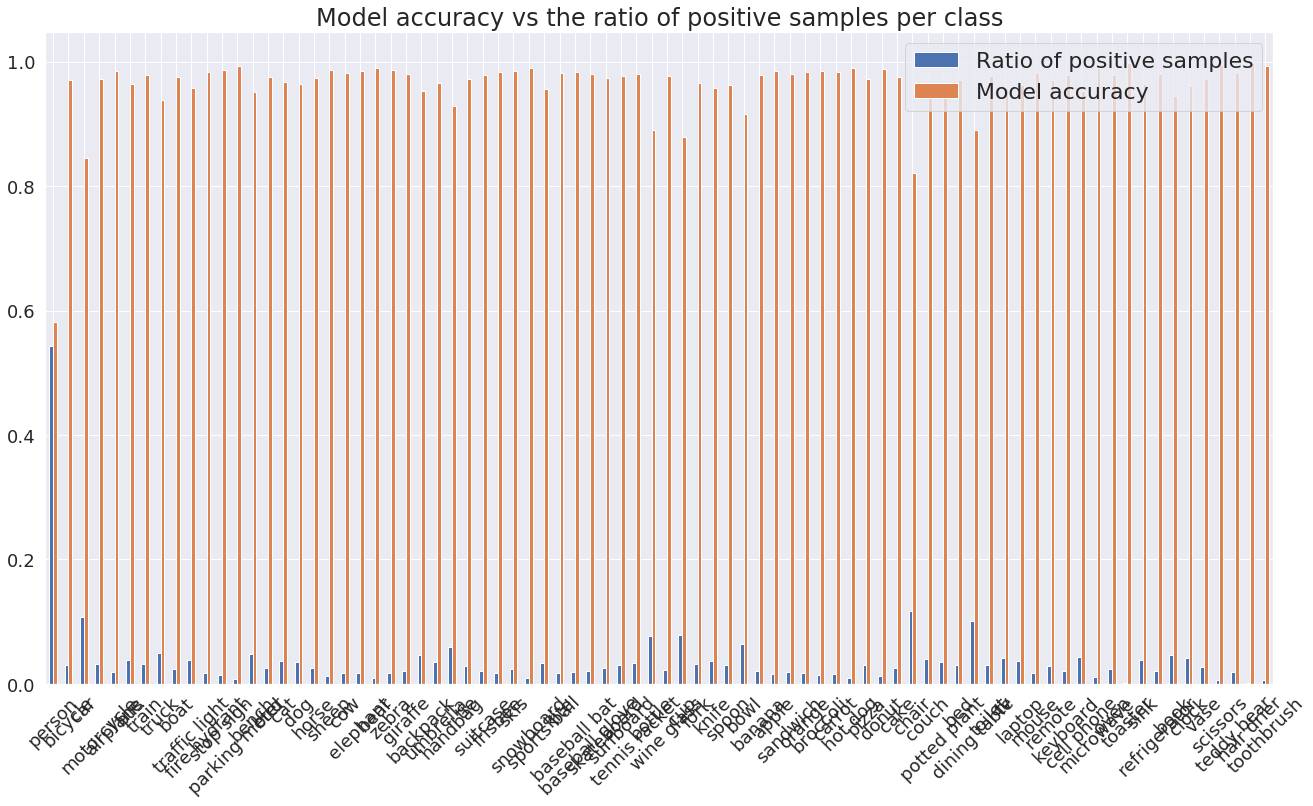

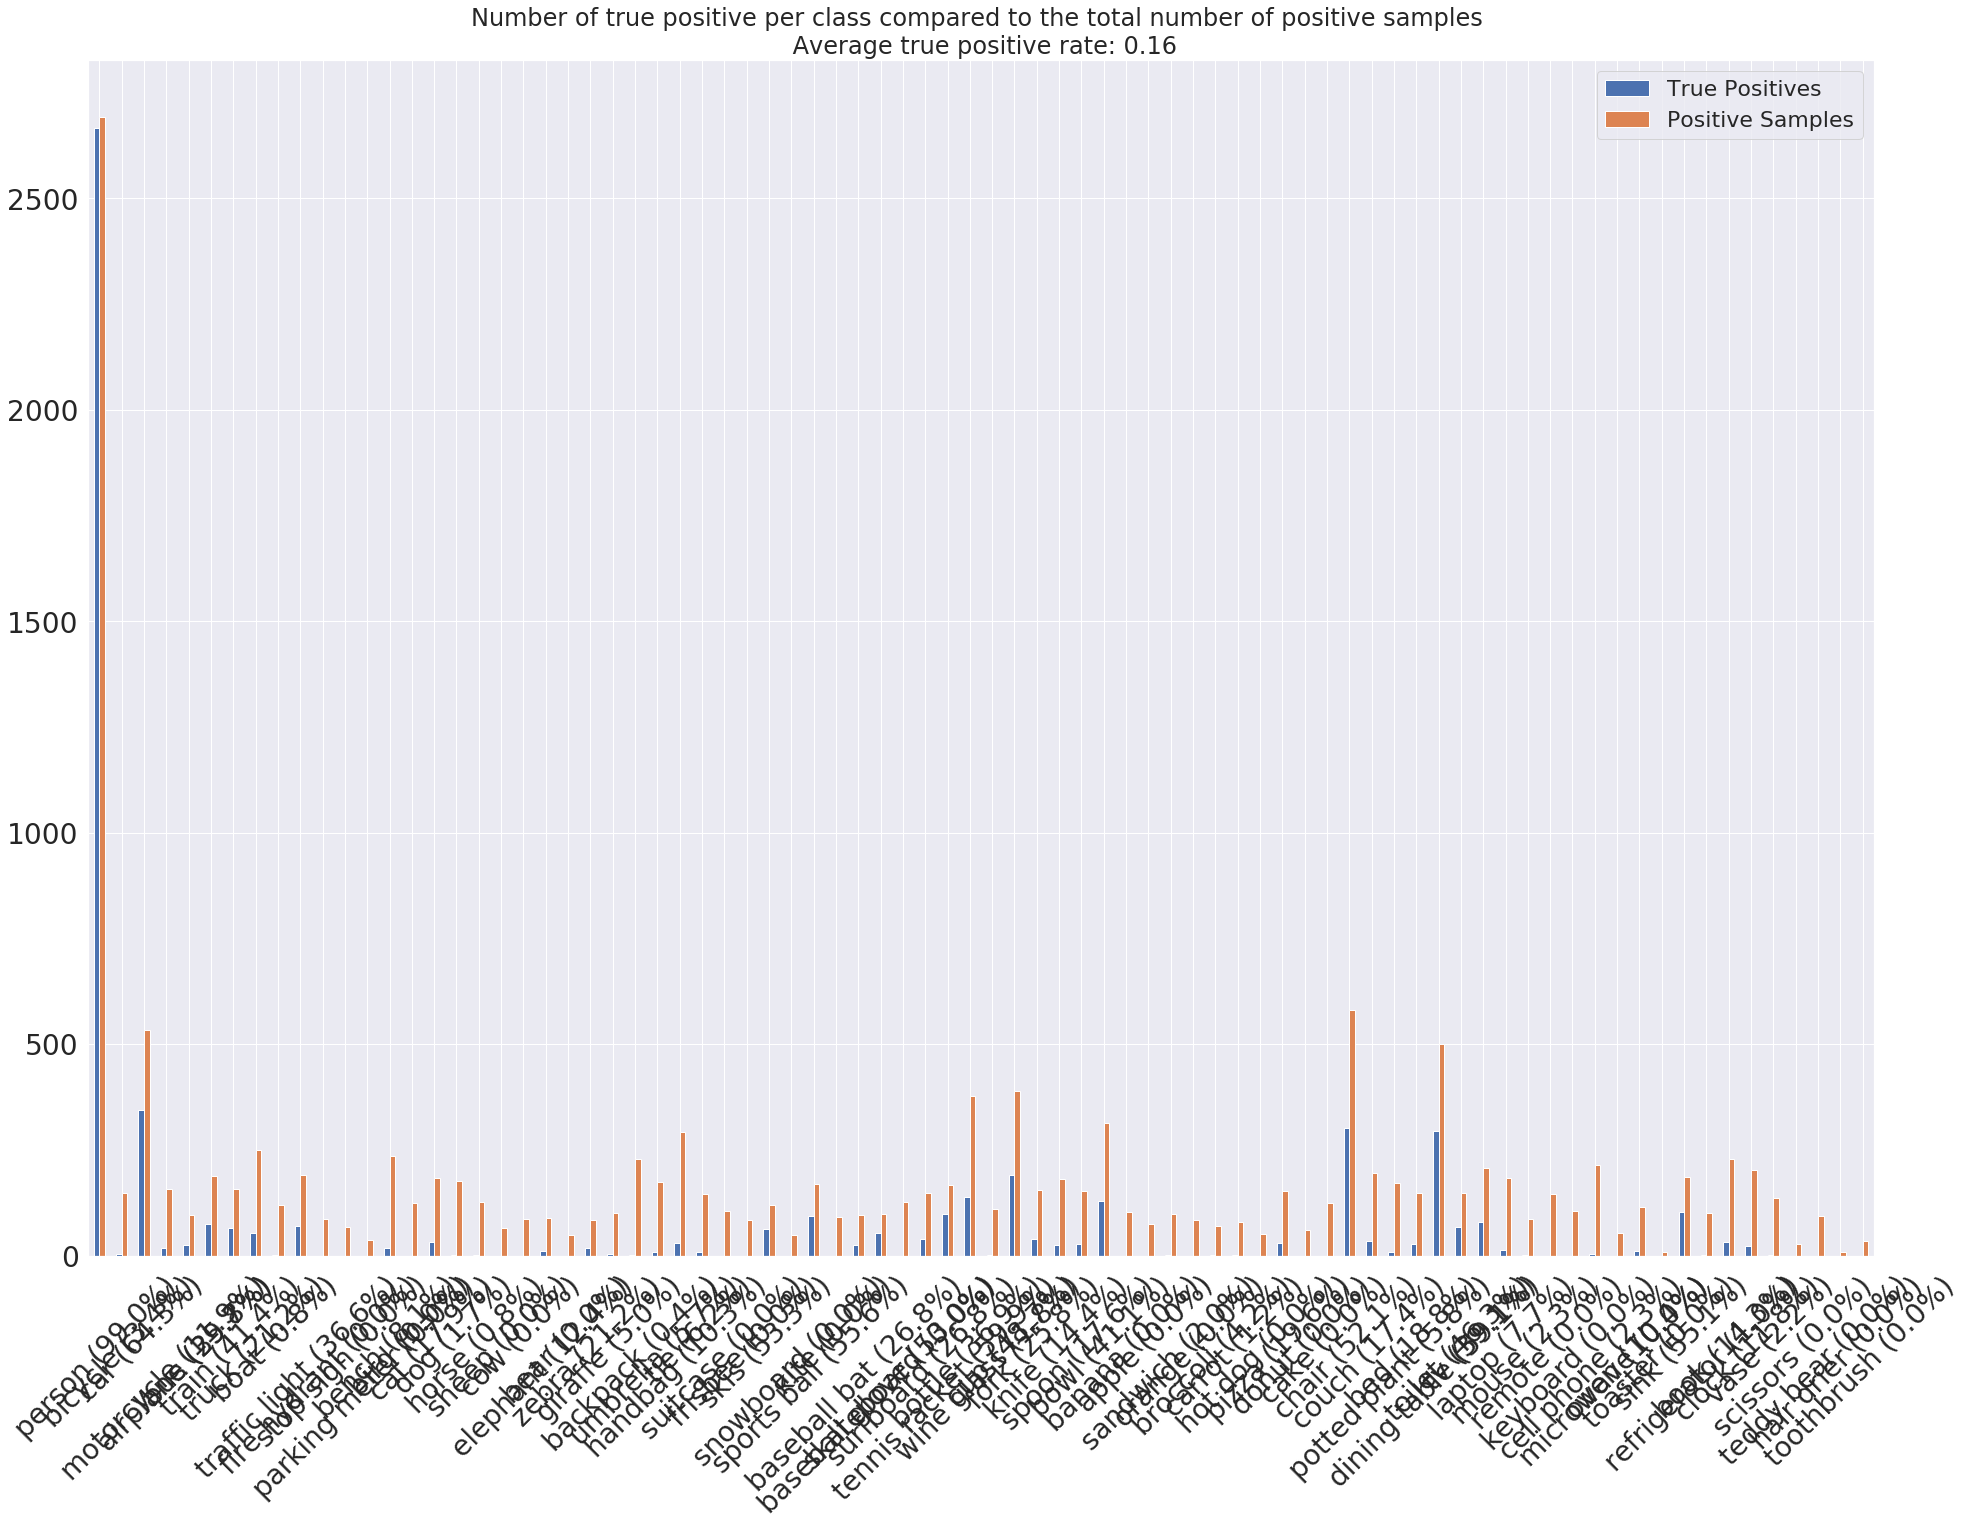

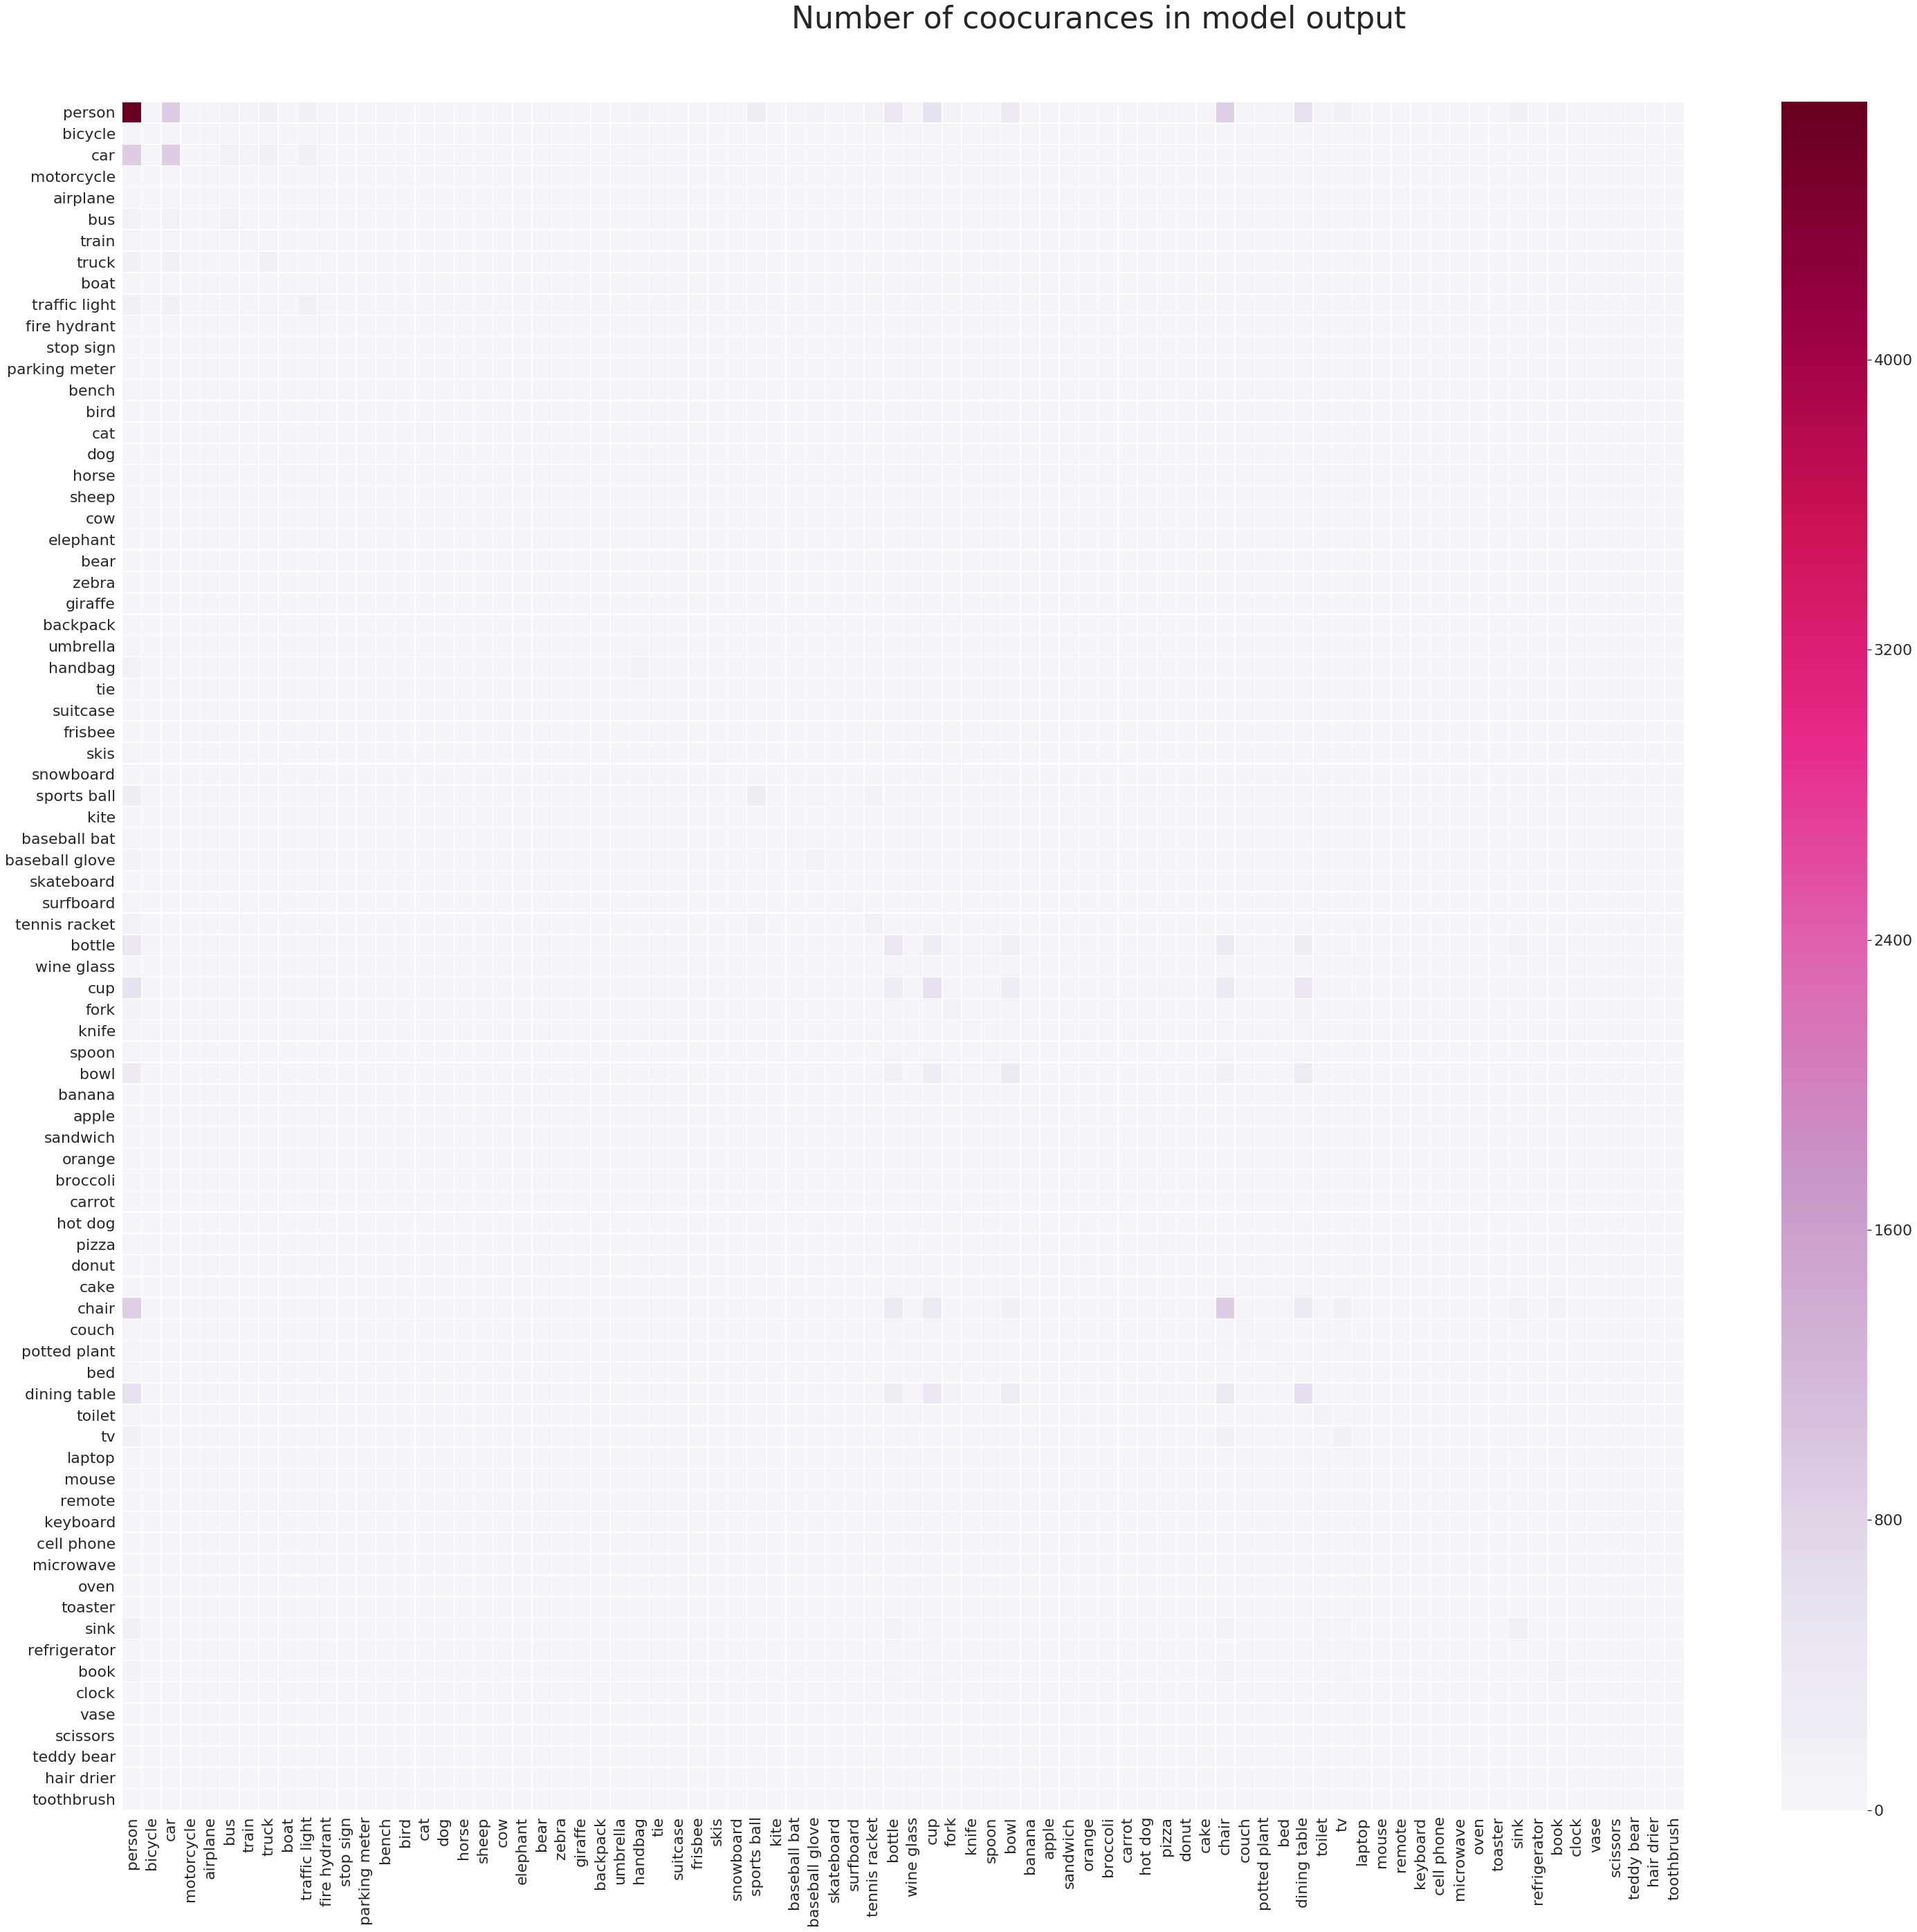

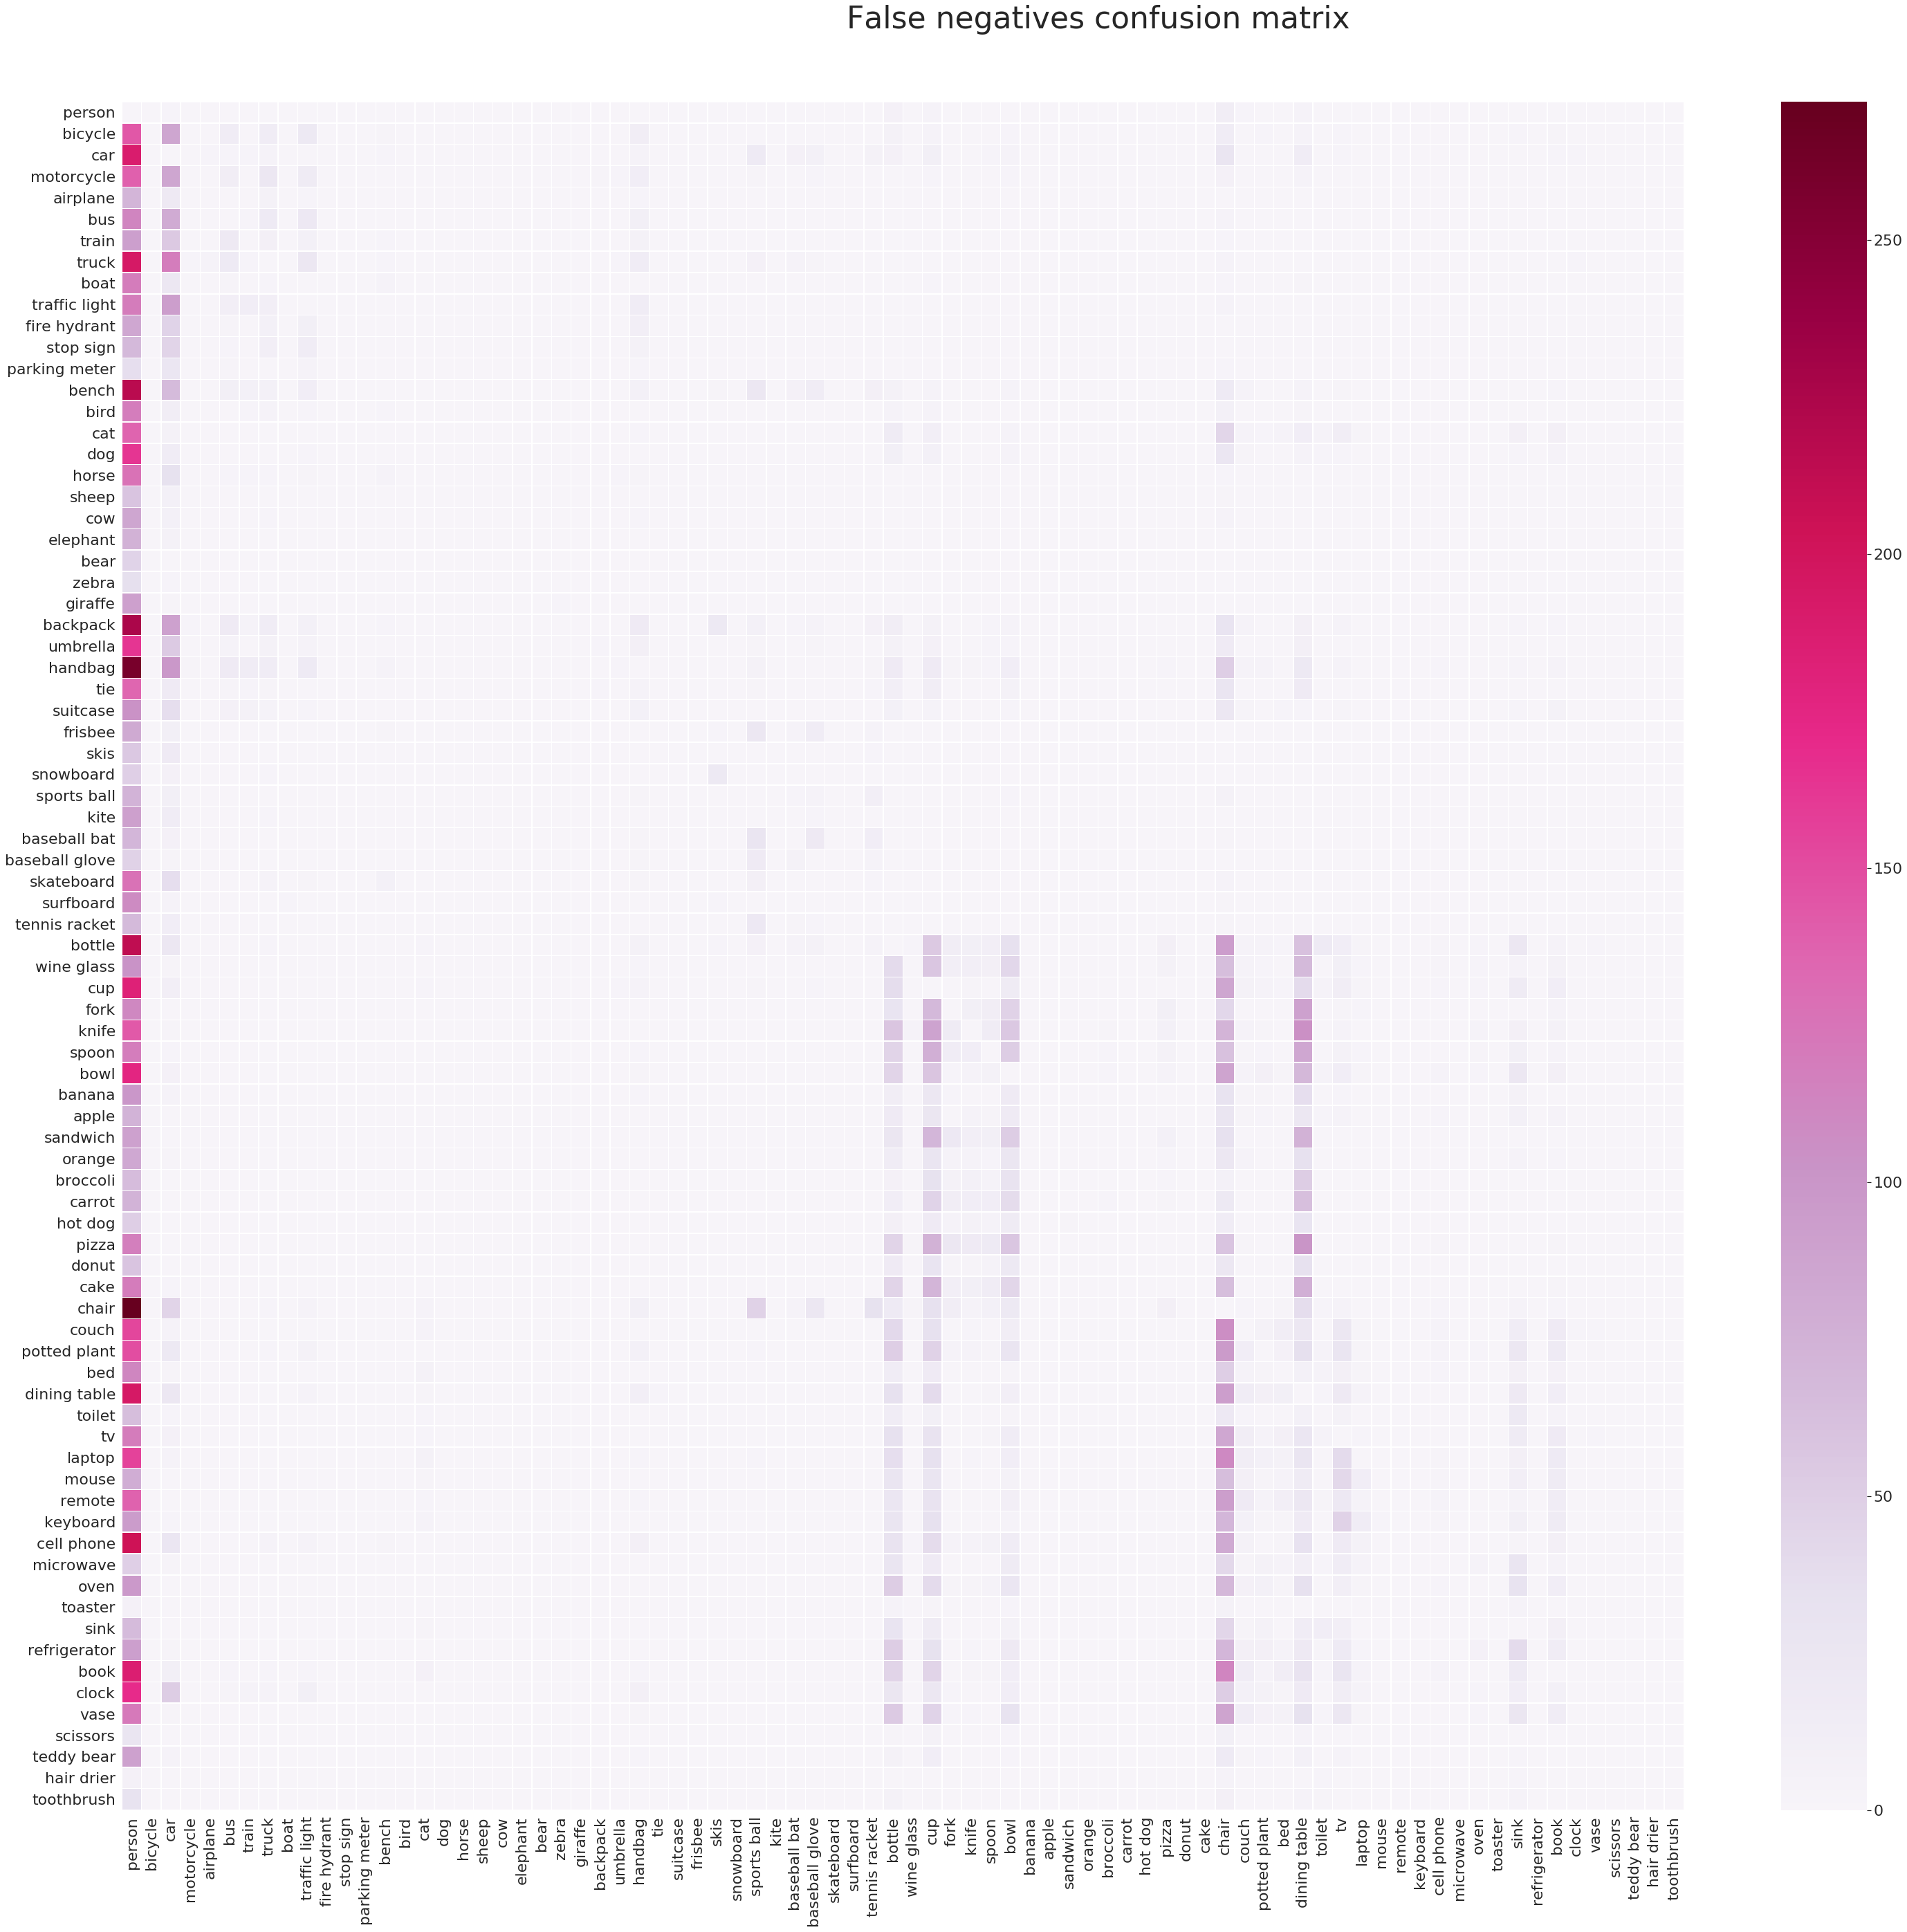

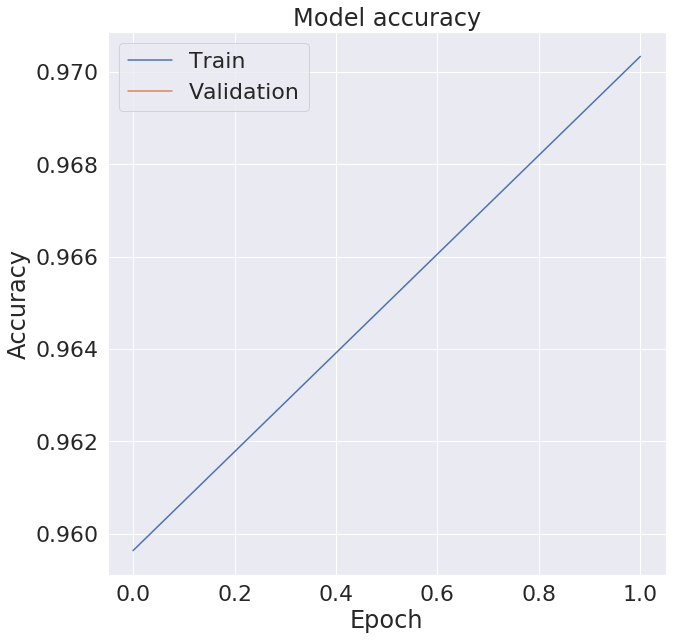

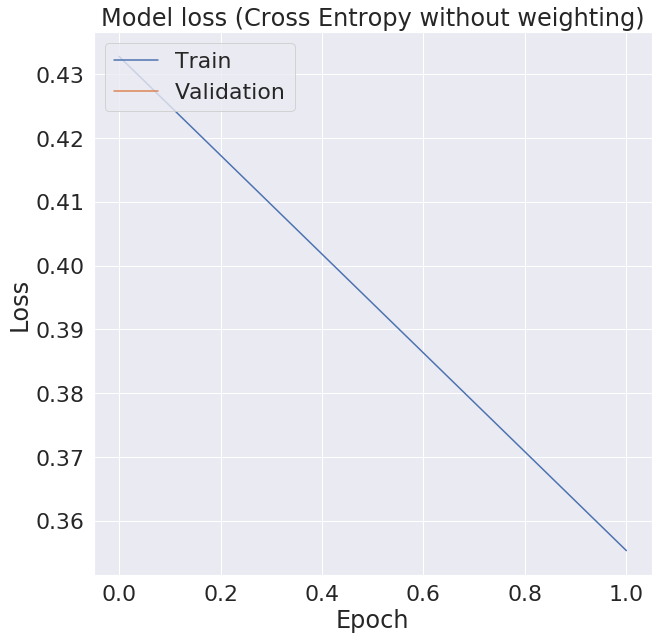

In [12]:
for ratio in np.arange(0.5,1,0.1):
    tf.reset_default_graph()
    EXPERIMENTNAME = "original_CE_ratio" + str(round(ratio, 1))
    print("Current Experiment: " + EXPERIMENTNAME + "\n\n\n")
    global_labels = pd.read_csv('/srv/workspace/research/mlml/mlml_weightedLoss/labels/missing_labels'+
                                str(round(ratio, 1))+'.csv')
    # Loading datasets
    training_dataset = get_dataset('/srv/workspace/research/mlml/mlml_weightedLoss/labels/missing_labels'+
                                   str(round(ratio, 1))+'.csv')
    with tf.Graph().as_default():
        # Setting up training generator
        training_iterator = training_dataset.make_one_shot_iterator()
        training_next_element = training_iterator.get_next()

        # Setting up variables
        input_labels = tf.placeholder(tf.float32, [None, NUM_CLASSES], name="true_labels")
        input_images = tf.placeholder(tf.float32, [None, 224, 224, 3], name="input")
        train_phase = tf.placeholder(tf.bool, name="is_training")

        #positive_weights = tf.placeholder(tf.float32, [None,15], name = "Positive_weights")
        #negative_weights = tf.placeholder(tf.float32, [None, 15], name="negative_weights")
        # Create the model, use the default arg scope to configure the batch norm parameters.
        with slim.arg_scope(inception.inception_v1_arg_scope()):
            ignored_logits, end_points = inception.inception_v1(input_images, num_classes=NUM_CLASSES, 
                                                       is_training=train_phase)
            
        featured_extracted = end_points['Mixed_5c']
        
        with tf.name_scope('trainable/Fully_connected_1'):
            flattened = tf.reshape(featured_extracted, [-1, 7*7* 1024])
            fully1 = tf.nn.sigmoid(full_layer(flattened, 256))

        with tf.name_scope('trainable/Fully_connected_2'):
            #dropped = tf.nn.dropout(fully1, keep_prob=current_keep_prob)
            output_logits = full_layer(fully1, NUM_CLASSES)

        trainable_layers = [var for var in tf.global_variables() if ("trainable" in var.op.name)]
        # Defining loss and metrics
        # Define loss and training optimizer
        #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output_logits, labels=input_labels))
        positive_imbalance_weights = tf.constant(Pos_balance_weights)
        loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(input_labels,output_logits,
                                                                       positive_imbalance_weights))
        probabilities = tf.nn.sigmoid(output_logits)
        tf.summary.histogram('outputs', probabilities)

        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(learning_rate=0.1, global_step=global_step, decay_steps=1000,
                                                  decay_rate=0.95,staircase=True)
        train_step = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss,var_list=trainable_layers)
        #my_weights_loss = weighted_loss(y_true= y, y_pred= model_output,
        #                             positive_weights= positive_weights, negative_weights= negative_weights)

        # define accuracy
        correct_prediction = tf.equal(tf.round(probabilities), input_labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # Adding tensorboard summaries
        tf.summary.scalar('Original_cross_entropy', loss)
        #tf.summary.scalar('Weighted cross entropy',  my_weights_loss)
        tf.summary.scalar('Accuracy', accuracy)
        # Merge all the summaries
        merged = tf.summary.merge_all()

        # restoring pretrained model weights
        checkpoint_exclude_scopes = ["InceptionV1/Logits", "InceptionV1/AuxLogits"]
        exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]
        variables_to_restore = []
        for var in slim.get_model_variables():
            for exclusion in exclusions:
                if var.op.name.startswith(exclusion):
                    break
            else:
                variables_to_restore.append(var)
        init_fn = slim.assign_from_checkpoint_fn(
            os.path.join(PRETRAINED_MODEL_DIR, 'inception_v1.ckpt'),
            variables_to_restore)

        # Setting up saving directory
        experiment_name = strftime("%Y-%m-%d_%H-%M-%S", localtime())
        exp_dir = os.path.join(OUTPUT_PATH, EXPERIMENTNAME, experiment_name)

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

        epoch_losses_history, epoch_accurcies_history, val_losses_history, val_accuracies_history = [], [], [], []
        #my_loss_history, my_loss_val_history = [], []
        with tf.Session() as sess:
            # Write summaries to LOG_DIR -- used by TensorBoard
            train_writer = tf.summary.FileWriter(exp_dir + '/tensorboard/train', graph=tf.get_default_graph())
            test_writer = tf.summary.FileWriter(exp_dir + '/tensorboard/test', graph=tf.get_default_graph())
            print("Execute the following in a terminal:\n" + "tensorboard --logdir=" + exp_dir)
            sess.run(tf.global_variables_initializer())
            init_fn(sess)
            for epoch in range(NUM_EPOCHS):
                batch_loss, batch_accuracy = np.zeros([TRAINING_STEPS, 1]), np.zeros([TRAINING_STEPS, 1])
                #batch_my_loss, val_my_loss = np.zeros([TRAINING_STEPS, 1]), np.zeros([VALIDATION_STEPS, 1])
                #val_accuracies, val_losses = np.zeros([VALIDATION_STEPS, 1]), np.zeros([VALIDATION_STEPS, 1])
                for batch_counter in range(TRAINING_STEPS):
                    batch = sess.run(training_next_element)
                    batch_images = batch[0]
                    batch_labels = np.squeeze(batch[1])
                    summary, batch_loss[batch_counter], batch_accuracy[batch_counter], _ \
                    = sess.run([merged, loss, accuracy, train_step],
                               feed_dict={input_images:batch_images,input_labels:batch_labels,train_phase:True})
                print("Epoch #{}".format(epoch+1), "Loss: {:.4f}".format(np.mean(batch_loss)),
                      "accuracy: {:.4f}".format(np.mean(batch_accuracy)))
                epoch_losses_history.append(np.mean(batch_loss))
                epoch_accurcies_history.append(np.mean(batch_accuracy))
                #my_loss_history.append(np.mean(batch_my_loss))
                # Add to summaries
                train_writer.add_summary(summary, epoch)
            
            os.makedirs(os.path.join(PRETRAINED_MODEL_DIR,EXPERIMENTNAME,experiment_name))
            save_path = saver.save(sess, os.path.join(PRETRAINED_MODEL_DIR,EXPERIMENTNAME, 
                                          experiment_name, "last_epoch.ckpt"))
            # Testing the model [I split the testset into smaller splits because of memory error]
            test_images, test_classes = load_test_set_raw()
            
            TEST_NUM_STEPS = 8  # number is chosen based on testset size to be dividable
            split_size = int(len(test_classes) / TEST_NUM_STEPS)
            test_pred_prob = np.zeros_like(test_classes, dtype=float)
            for test_split in range(TEST_NUM_STEPS):
                start_idx = (test_split * split_size)
                end_idx = (test_split * split_size) + split_size
                images_split = test_images[start_idx:end_idx, :, :]
                test_pred_prob[start_idx:end_idx, :] = sess.run(probabilities,
                                                                feed_dict={input_images: images_split,
                                                                           train_phase: False})
            accuracy, auc_roc, hamming_error = evaluate_model(test_pred_prob, test_classes,
                                                              saving_path=exp_dir,
                                                              evaluation_file_path= \
                                                              os.path.join(exp_dir,"evaluation_results.txt"))

            results = create_analysis_report(test_pred_prob, test_classes, exp_dir, LABELS_LIST)

        
        # Plot and save losses
        plot_loss_acuracy(epoch_losses_history, epoch_accurcies_history,val_losses_history, 
                          val_accuracies_history,exp_dir)
    break

## testing trained model

In [ ]:
for ratio in ratios:  [DONE]
    train model [DONE]
    evaluate model [DONE]
    

for ratio in ratios: 
    train model with weighted loss 
    evaluate model
    
Save all results in a dataframe 
plot figure 
WIN$$

In [256]:
training_dataset = get_dataset('/srv/workspace/research/mlml/mlml_weightedLoss/labels/missing_labels'+
                               str(round(ratio, 1))+'.csv')
# Setting up model
training_iterator = training_dataset.make_one_shot_iterator()
training_next_element = training_iterator.get_next()
with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    #init_fn(sess)
    batch = sess.run(training_next_element)
    #batch_images = batch[0]
    #batch_labels = np.squeeze(batch[1])
#summary, batch_loss[batch_counter], batch_accuracy[batch_counter], _ = sess.run([merged, loss, accuracy, train_step],
#                                                                                            feed_dict={input_images:batch_images,
#                                                                                                      labels:batch_labels,
#                                                                                                      train_phase:True})

image32
image71
label32
image50label71

image90
label50
image57
label90
image66
label57
image65
label66
image47
label65
image70
label47
image24label70

image80
label24
image82label80

image13label82

image9
label13
image68
label9
image96
label68
image30
label96
image102
label30
image17
label102
image43label17

image73
label43
image10
label73
image120
label10
image29
label120
image6
label29
image100
label6
image77
label100
image27label77

image101
label27
label101
image88
image62
label88
image15
label62
image107
label15
label107
image11


(-0.5, 223.5, 223.5, -0.5)

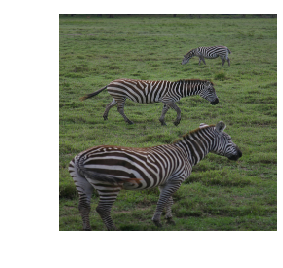

In [269]:
image = np.load(os.path.join(IMAGES_PATH, str(0) + '.npz'))['image']
image = image.astype(np.float32)
image /= 255.0
image = (image - INPUT_IMAGE_MEAN) / INPUT_IMAGE_STD
image = resize(image, INPUT_SHAPE)
image = image.astype(np.float32)
plt.imshow(image)
plt.axis('off')

## Testing pretrained model is predicting correctly

INFO:tensorflow:Restoring parameters from /srv/workspace/research/mlml/pretrained_models/inception_v1.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


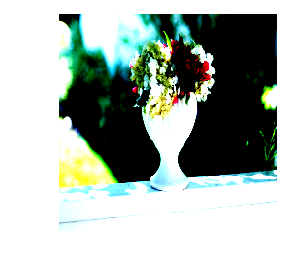

Probability 20.26% => [vase]
Probability 14.84% => [pot, flowerpot]
Probability 5.65% => [picket fence, paling]
Probability 4.76% => [hummingbird]
Probability 4.50% => [daisy]


In [121]:
from datasets import imagenet
with tf.Graph().as_default():
    image = np.load(os.path.join(IMAGES_PATH, str(2) + '.npz'))['image']
    image = image.astype(np.float32)
    image /= 255.0
    image = (image - INPUT_IMAGE_MEAN) / INPUT_IMAGE_STD
    #image -= 0.5
    #image *= 2.0
    image = resize(image, INPUT_SHAPE)
    image = image.astype(np.float32)
    processed_image  = np.expand_dims(image, 0)

    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(processed_image, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(PRETRAINED_MODEL_DIR, 'inception_v1.ckpt'),
        slim.get_model_variables('InceptionV1'))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        init_fn(sess)
        probabilities = sess.run([probabilities])
        probabilities = probabilities[0][0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))